In [1]:
import math 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os; 
print(os.getcwd())
import cvxpy as cp
from multiprocessing import Pool
from joblib import Parallel, delayed

c:\Users\TGY\MIT Dropbox\Wallace Yion\Research\Braatz\Fourth Paper\Submission Code\Multistep Koopman


In [2]:
def _box_tensors(box, dtype, device):
    box = torch.as_tensor(box, dtype=dtype, device=device)  # shape (2,2): [[xmin,xmax],[ymin,ymax]]
    xmin, xmax = box[:,0], box[:,1]
    alpha = 0.5*(xmax - xmin)          # scale
    beta  = 0.5*(xmax + xmin)          # offset
    return xmin, xmax, alpha, beta

def to_box_scaled(X, box):
    """Map raw X (N,2) to U in [-1,1]^2 for an arbitrary box."""
    xmin, xmax, alpha, beta = _box_tensors(box, X.dtype, X.device)
    return (X - beta) / (alpha + 1e-12)

def from_box_scaled(U, box):
    """Inverse: map U in [-1,1]^2 back to raw X."""
    xmin, xmax, alpha, beta = _box_tensors(box, U.dtype, U.device)
    return alpha*U + beta

# ---------- 1D Legendre (orthonormal on [-1,1]) ----------
def legendre1d_orthonorm(x, deg):
    """
    φ_n(x) = sqrt((2n+1)/2) * P_n(x), with P_0=1, P_1=x, P_{n+1} = ((2n+1)xP_n - nP_{n-1})/(n+1)
    x: (N,) in [-1,1]. Returns Phi: (N, deg+1).
    """
    x = x.reshape(-1, 1)
    N = x.shape[0]
    Phi = torch.zeros((N, deg+1), dtype=x.dtype, device=x.device)
    Phi[:, 0] = math.sqrt(0.5)
    if deg == 0: return Phi
    Phi[:, 1] = math.sqrt(1.5) * x.squeeze(1)
    P0 = torch.ones_like(x)     # P_0
    P1 = x.clone()              # P_1
    for n in range(1, deg):
        P2 = ((2*n+1)*x*P1 - n*P0) / (n+1)    # P_{n+1}
        Phi[:, n+1] = math.sqrt((2*n+3)/2.0) * P2.squeeze(1)
        P0, P1 = P1, P2
    return Phi

# ---------- 2D tensor-product Legendre dictionary on an arbitrary box ----------
def legendre2d_phi_box(X, box, deg, include_bias=True, total_degree=True , verbose = False):
    """
    X:   (N,2) raw states (any rectangle)
    box: [[xmin,xmax],[ymin,ymax]]
    deg: max polynomial degree
    include_bias: prepend constant 1 column
    total_degree: keep (i,j) with i+j<=deg (True) or full grid (False)

    Returns:
      Z:         (N,p) dictionary built on scaled coords U∈[-1,1]^2
      Csel_u:    (2,p) linear decoder to recover U from Z
      Csel_x:    (2,p) linear decoder to recover raw X from Z (uses bias for offset)
      pairs:     list of (i,j) for each non-bias column in Z
    """
    assert X.shape[1] == 2
    # scale to unit box
    U = to_box_scaled(X, box)                 # (N,2) in [-1,1]^2
    x, y = U[:,0], U[:,1]

    Phi_x = legendre1d_orthonorm(x, deg)      # (N,deg+1)
    Phi_y = legendre1d_orthonorm(y, deg)

    cols, pairs = [], []
    if include_bias:
        cols.append(torch.ones((X.shape[0],1), dtype=X.dtype, device=X.device))

    for i in range(deg+1):
        for j in range(deg+1):
            if i == 0 and j == 0:
                continue  # bias already added
            if total_degree and (i+j > deg):
                continue
            cols.append(Phi_x[:, i:i+1] * Phi_y[:, j:j+1])  # φ_i(x)*φ_j(y)
            pairs.append((i,j))

    Z = torch.cat(cols, dim=1)                # (N,p)

    # decoder to U uses columns (1,0) and (0,1):
    # φ1(x)φ0(y) = (sqrt(3)/2)*x, φ0(x)φ1(y) = (sqrt(3)/2)*y
    s = math.sqrt(3.0) / 2.0
    off = 1 if include_bias else 0
    try:
        idx10 = pairs.index((1,0)) + off
        idx01 = pairs.index((0,1)) + off
    except ValueError:
        raise RuntimeError("Dictionary lacks linear terms (1,0) and/or (0,1). Use deg>=1.")

    Csel_u = torch.zeros((2, Z.shape[1]), dtype=X.dtype, device=X.device)
    Csel_u[0, idx10] = 1.0 / s
    Csel_u[1, idx01] = 1.0 / s

    # decoder to raw X: x = alpha*u + beta (element-wise)
    _, _, alpha, beta = _box_tensors(box, X.dtype, X.device)  # shape (2,)
    Csel_x = alpha.unsqueeze(1) * Csel_u                       # scale the U rows
    if include_bias:
        Csel_x[:, 0] += beta                                   # add offsets via bias colum
    
    if verbose:
        return Z, Csel_u, Csel_x, U, pairs
    return Z


def decode_legendre2d(Z, pairs, box, include_bias=True):
    """
    Recover U (scaled coords) and X (original coords) from the dictionary Z
    built by your legendre2d_phi_box(...).

    Args:
      Z:   (N,p) feature matrix
      pairs: list of (i,j) for the non-bias columns (exactly as returned)
      box: [[xmin,xmax],[ymin,ymax]]
      include_bias: True if Z's first column is the bias 1

    Returns:
      U_hat: (N,2) in [-1,1]^2
      X_hat: (N,2) in original coordinates
    """
    # indices of linear terms
    off = 1 if include_bias else 0
    try:
        idx10 = pairs.index((1,0)) + off
        idx01 = pairs.index((0,1)) + off
    except ValueError:
        raise RuntimeError("Need linear terms (1,0) and (0,1); use deg >= 1.")

    # With your orthonormalization: φ1(x)=√(3/2) x, φ0(y)=√(1/2),
    # so φ1(x)φ0(y) = (√3/2) x, same for y.
    s = math.sqrt(3.0) / 2.0

    dtype, device = Z.dtype, Z.device
    U_hat = torch.empty((Z.shape[0], 2), dtype=dtype, device=device)
    U_hat[:, 0] = Z[:, idx10] / s
    U_hat[:, 1] = Z[:, idx01] / s

    # Rescale to raw coordinates: x = alpha * u + beta (per axis)
    xmin, xmax = box[0]
    ymin, ymax = box[1]
    alpha = torch.tensor([(xmax - xmin)/2.0, (ymax - ymin)/2.0], dtype=dtype, device=device)
    beta  = torch.tensor([(xmax + xmin)/2.0, (ymax + ymin)/2.0], dtype=dtype, device=device)

    X_hat = U_hat * alpha + beta
    return U_hat, X_hat

In [3]:
# -------------------- Config --------------------
SEED     = 7
rng      = np.random.default_rng(SEED)

mu      = 5.0
w0       = 0.8
b        = 1.0

Ts       = 0.01        # step (s)
T_steps  = 21       # steps per trajectory
N_traj   = 20000          # number of trajectories (distinct theta/ICs)

# Input (PRBS-like)
U_AMP      = 0.5
MIN_HOLD   = 10         # min dwell (steps)
MAX_HOLD   = 40         # max dwell (steps)

SAVE_PATH = "vdp_multistep.npz"  # output file

# --------------- Van der Pol + RK4 ---------------
def vdp_rhs(x, u, mu, w0, b):
    x1, x2 = x
    dx1 = x2
    dx2 = mu * (1.0 - x1**2) * x2 - (w0**2) * x1 + b * u
    return np.array([dx1, dx2], dtype=np.float64)

def rk4_step(x, u, dt, mu, w0, b):
    k1 = vdp_rhs(x, u, mu, w0, b)
    k2 = vdp_rhs(x + 0.5*dt*k1, u, mu, w0, b)
    k3 = vdp_rhs(x + 0.5*dt*k2, u, mu, w0, b)
    k4 = vdp_rhs(x + dt*k3, u, mu, w0, b)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)



def make_prbs_sequence(T, amp, rng, min_hold=10, max_hold=40):
    """Piecewise-constant ±amp with random dwell lengths (in steps)."""
    seq = np.empty(T, dtype=np.float64)
    t = 0
    while t < T:
        hold = int(rng.integers(min_hold, max_hold + 1))
        val = amp if rng.random() < 0.5 else -amp
        seq[t:t+hold] = val
        t += hold
    return seq[:T]

# --------------- Dataset generation ---------------
def generate_dataset(N_traj, T_steps, Ts, rng):
    n, m = 2, 1
    Xs, Ys, Us = [], [], []
    for _ in range(N_traj):      # θ ∈ [-1,1]

        x = rng.uniform(-2.0, 2.0, size=(2,)).astype(np.float64)
        # Input sequence
        u_seq = make_prbs_sequence(T_steps, U_AMP, rng, MIN_HOLD, MAX_HOLD)

        # Simulate
        X_traj = np.empty((n, T_steps), dtype=np.float64)
        for k in range(T_steps):
            X_traj[:, k] = x
            x = rk4_step(x, u_seq[k], Ts, mu, w0, b)

        # Snapshots
        Xs.append(X_traj[:, :-1])               # x_k
        Ys.append(X_traj[:, 1:])                # x_{k+1}
        Us.append(u_seq[:-1][None, :])          # u_k

    X = np.stack(Xs, axis=0)              # (2, N)
    Y = np.stack(Ys, axis=0)              # (2, N)
    U = np.stack(Us, axis=0)              # (1, N)
    return X, Y, U



In [4]:
if __name__ == "__main__":
    X, Y, U = generate_dataset(N_traj, T_steps, Ts, rng)

    np.savez_compressed(
        SAVE_PATH, X=X, Y=Y, U=U,
        Ts=Ts, mu=mu, w0=w0, b=b,N_traj=N_traj,T_steps=T_steps,
        meta=dict(
            description="Van der Pol dataset for Multistep Koopman",
            seed=SEED, N_traj=N_traj, T_steps=T_steps
        )
    )

    print("Saved:", SAVE_PATH)
    print("Shapes:",
          "X", X.shape, "Y", Y.shape, "U", U.shape)

Saved: vdp_multistep.npz
Shapes: X (20000, 2, 20) Y (20000, 2, 20) U (20000, 1, 20)


In [5]:
# ---- load or create your data as numpy arrays (columns = samples) ----
# X: (n, N), Y: (n, N), U: (m, N), THETA: (N,)
# For demo, we'll create placeholders; replace these with your data.
n, m = X.shape[1], U.shape[1]
# ---------- build features (ψ) ----------


X_init = torch.tensor(X[:, :, 0])
Yt = torch.tensor(Y)

# X,Y are torch tensors of shape (N,2) in *raw* units
box = [[-2.0, 2.0], [-2.0, 2.0]]   # <-- your rectangle (can be symmetric [-L,L],[-L,L] too)
deg_poly = 10
Z, Csel_u, Csel_x, _, pairs = legendre2d_phi_box(X_init, box, deg_poly, include_bias=True, total_degree=True, verbose=True)                       # (N, p)
# ---- feature-wise standardization (learn from Z; use train split if you have one) ----

print(Z.shape)
print(Yt.shape)
p  = Z.shape[1]

# decode matrix: first n features are the raw x (by construction)
Csel = torch.zeros((n, p)); Csel[:, :n] = torch.eye(n)



torch.Size([20000, 66])
torch.Size([20000, 2, 20])


In [6]:
def solve_row(G, Hk, y, beta=1e-3, tau=1e-2):
    """
    Solve min || G Ei_k + Hk Fi_k - y ||^2
            + beta ( ||[Ei_k; Fi_k]||_2^2 + tau ||Ei_k||_1 )
    """
    # G: (M,p), Hk: (M,k*m), y: (M,)
    # returns Ei_k: (p,), Fi_k: (k*m,), status
    Phi = np.concatenate([G, Hk], axis=1)   # (M, p + k*m)
    p = G.shape[1]                          # size of Ei_k
    d = Phi.shape[1]                        # p + k*m

    w = cp.Variable(d)      # stack [Ei_k; Fi_k]
    Ei = w[:p]              # first p entries
    Fi = w[p:]              # rest

    loss = cp.sum_squares(Phi @ w - y)  # fit term
    reg  = beta * (cp.sum_squares(w) + tau * cp.norm1(Ei))
    prob = cp.Problem(cp.Minimize(loss + reg))
    prob.solve(solver=cp.OSQP, verbose=False)

    return w.value[:p], w.value[p:], prob.status



In [7]:
print(Z.shape)
i_trial = 1
k_trial = 3

G = Z.numpy()
print(G.shape)
Hk = U[:,:,0:k_trial].reshape(U[:,:,0:k_trial].shape[0], -1)  # shape (2,12)
print(Hk.shape)
y = Y[:,i_trial,k_trial]
print(y.shape)


solve_row(G, Hk, y, beta=1e-3, tau=1e-2)
U.shape

torch.Size([20000, 66])
(20000, 66)
(20000, 3)
(20000,)


(20000, 1, 20)

In [8]:

n_x = Y.shape[1]
H = Y.shape[2]
E_array = []
F_array = []
statuses_array = []
G = Z.numpy()
for k in range(H):
    n_jobs = -1
    Hk = U[:,:,0:k+1].reshape(U[:,:,0:k+1].shape[0], -1)  # shape (2,12)
    results = Parallel(n_jobs=n_jobs)(
            delayed(solve_row)(G, Hk, Y[:, i, k])
            for i in range(n_x)
        )
    E_k = np.vstack([res[0] for res in results])   # (n_x, p)
    F_k = np.vstack([res[1] for res in results])   # (n_x, k*m)
    statuses = [res[2] for res in results]
    E_array.append(E_k)
    F_array.append(F_k)
    statuses_array.append(statuses)
    print(E_k.shape)
    print(F_k.shape)



(2, 66)
(2, 1)
(2, 66)
(2, 2)
(2, 66)
(2, 3)
(2, 66)
(2, 4)
(2, 66)
(2, 5)
(2, 66)
(2, 6)
(2, 66)
(2, 7)
(2, 66)
(2, 8)
(2, 66)
(2, 9)
(2, 66)
(2, 10)
(2, 66)
(2, 11)
(2, 66)
(2, 12)
(2, 66)
(2, 13)
(2, 66)
(2, 14)
(2, 66)
(2, 15)
(2, 66)
(2, 16)
(2, 66)
(2, 17)
(2, 66)
(2, 18)
(2, 66)
(2, 19)
(2, 66)
(2, 20)


In [9]:
# Stack E vertically: (H*n_x, p)
E = np.vstack(E_array)

# Assemble block-lower-triangular F: (H*n_x, H*m)
n_x, p = E_array[0].shape
m = F_array[-1].shape[1] // H if H > 1 else F_array[0].shape[1]
F = np.zeros((H * n_x, H * m))

for k in range(H):
    row_start = k * n_x
    row_end   = (k+1) * n_x
    col_end   = F_array[k].shape[1]
    F[row_start:row_end, :col_end] = F_array[k]

print(E.shape)
print(F.shape)

(40, 66)
(40, 20)


In [10]:
def open_loop_predict(E, F, psi_xt, U_seq, n_x, N):
    """
    E: (N*n_x, p)
    F: (N*n_x, N*m)
    psi_xt: (p,)  -- lifted observables at x_t
    U_seq:  (N*m,) -- stacked inputs [u_t, ..., u_{t+N-1}]
    n_x: state dimension
    N: horizon length

    Returns
    -------
    X_pred: (N, n_x) predicted states
    """
    stacked = E @ psi_xt + F @ U_seq   # (N*n_x,)
    X_pred = stacked.reshape(N, n_x)
    return X_pred

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(X_true, X_pred=None, title="Trajectory comparison"):
    """
    Plot 2D state trajectories over horizon.
    
    X_true: (N, 2) array of ground-truth trajectory
    X_pred: (N, 2) array of predicted trajectory (optional)
    """
    N = X_true.shape[0]
    t = np.arange(1, N+1)

    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # First state
    axs[0].plot(t, X_true[:, 0], label="true", color="black")
    if X_pred is not None:
        axs[0].plot(t, X_pred[:, 0], "--", label="pred", color="red")
    axs[0].set_ylabel("x1")
    axs[0].legend()

    # Second state
    axs[1].plot(t, X_true[:, 1], label="true", color="black")
    if X_pred is not None:
        axs[1].plot(t, X_pred[:, 1], "--", label="pred", color="red")
    axs[1].set_ylabel("x2")
    axs[1].set_xlabel("time step")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

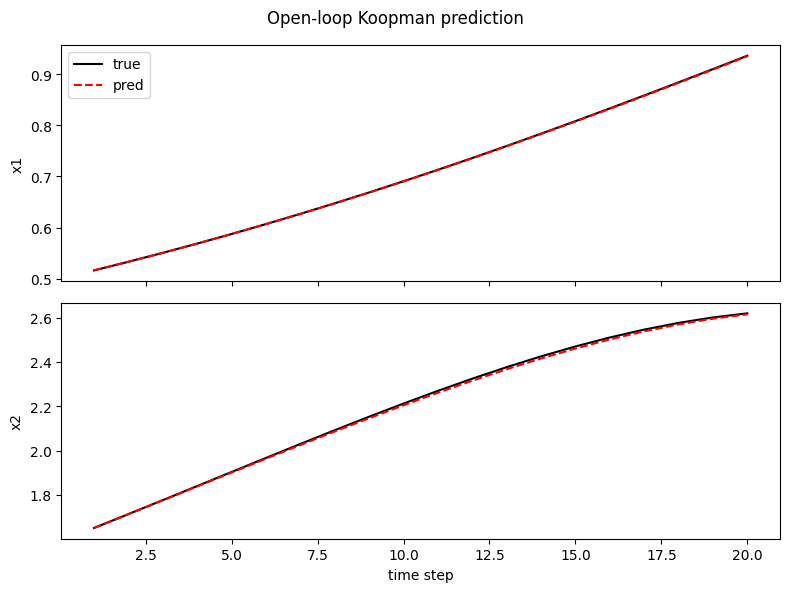

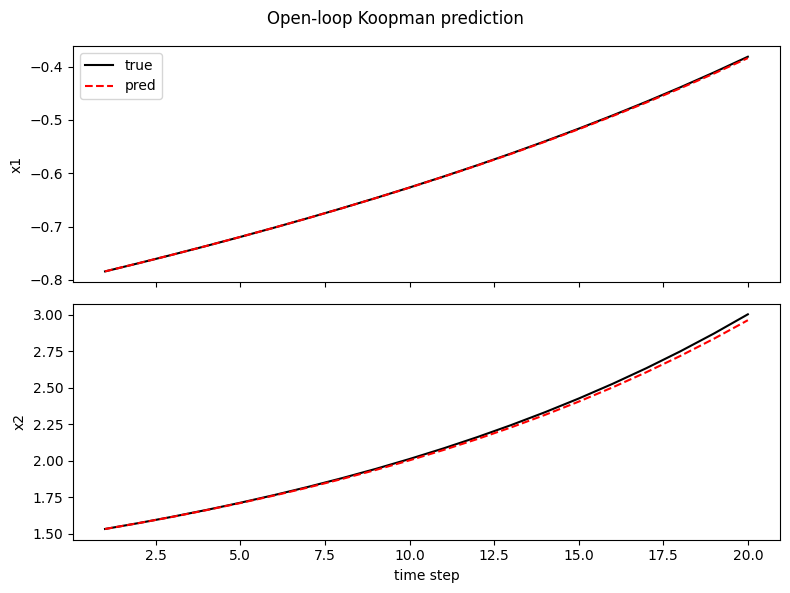

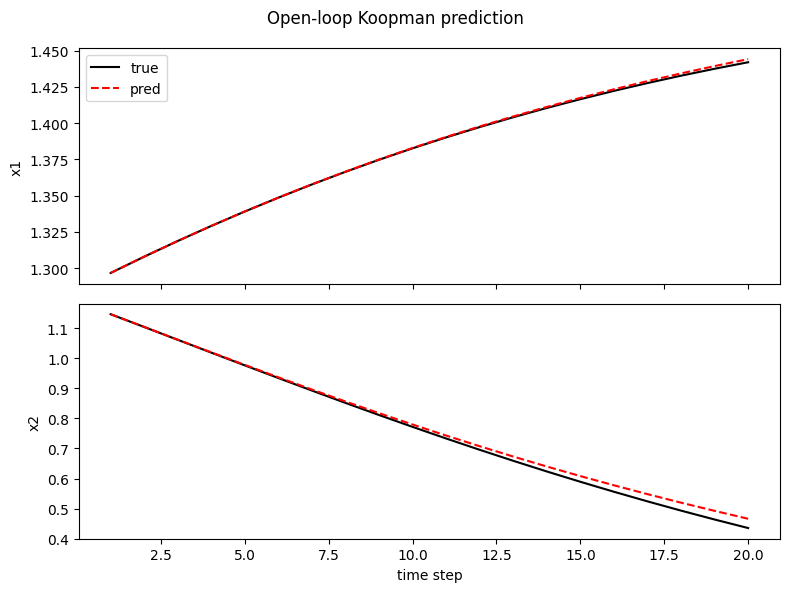

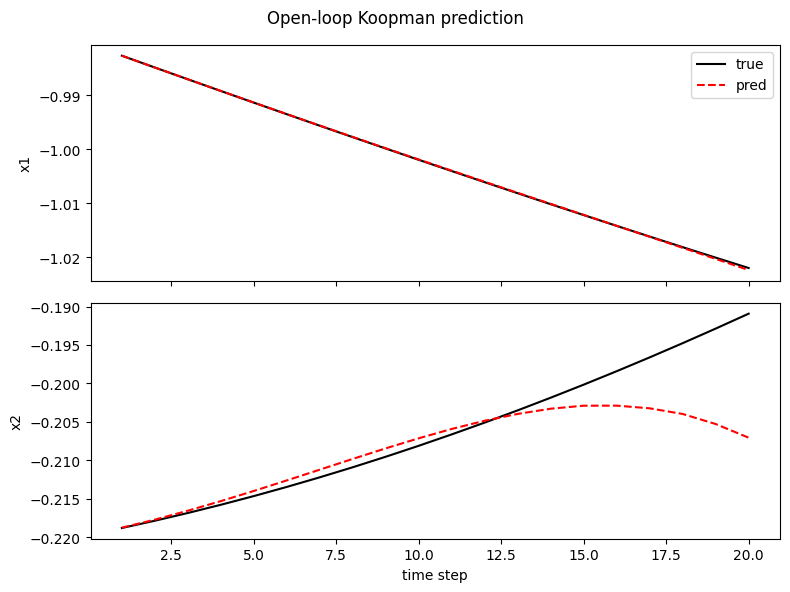

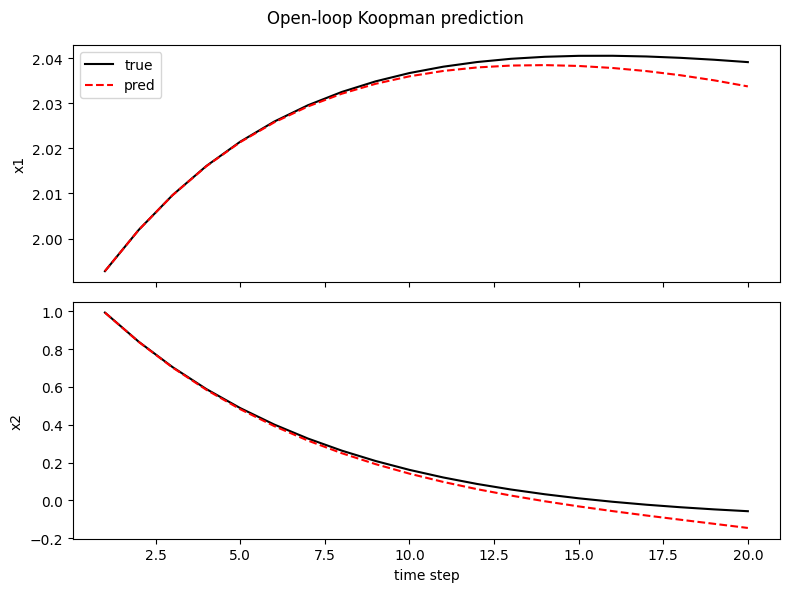

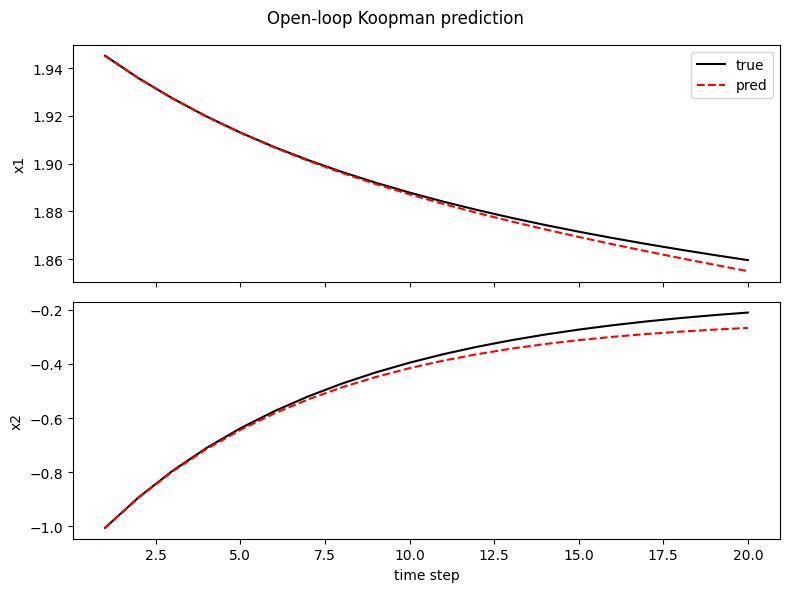

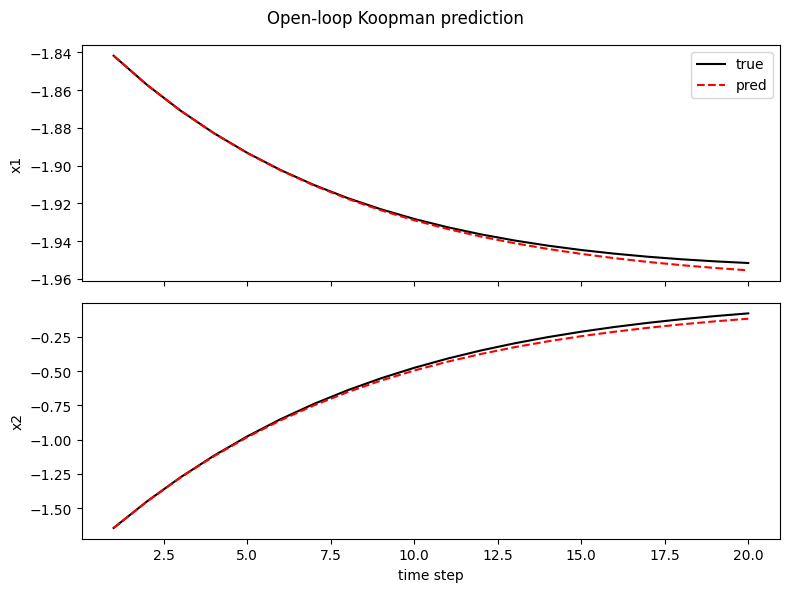

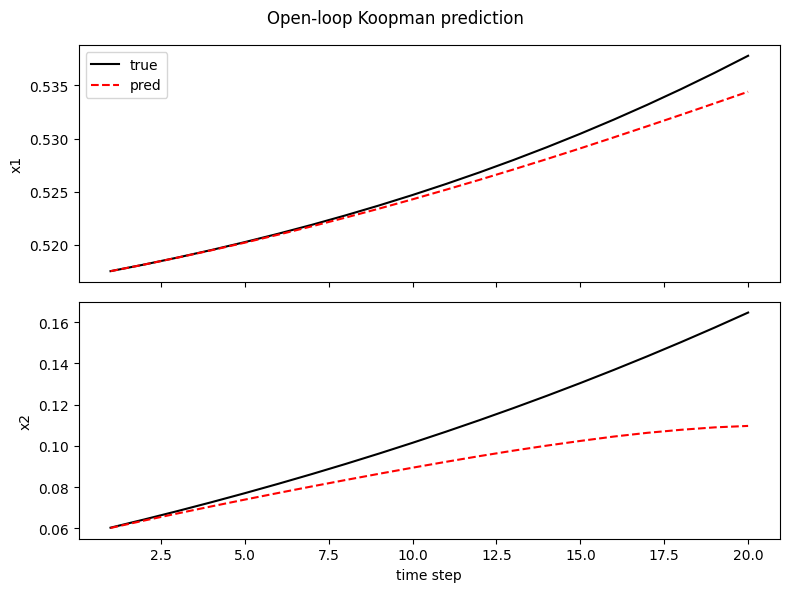

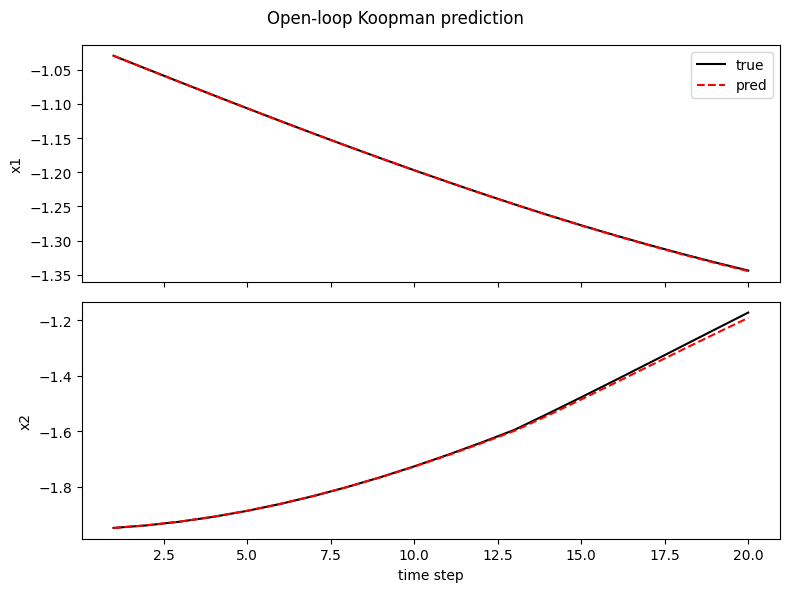

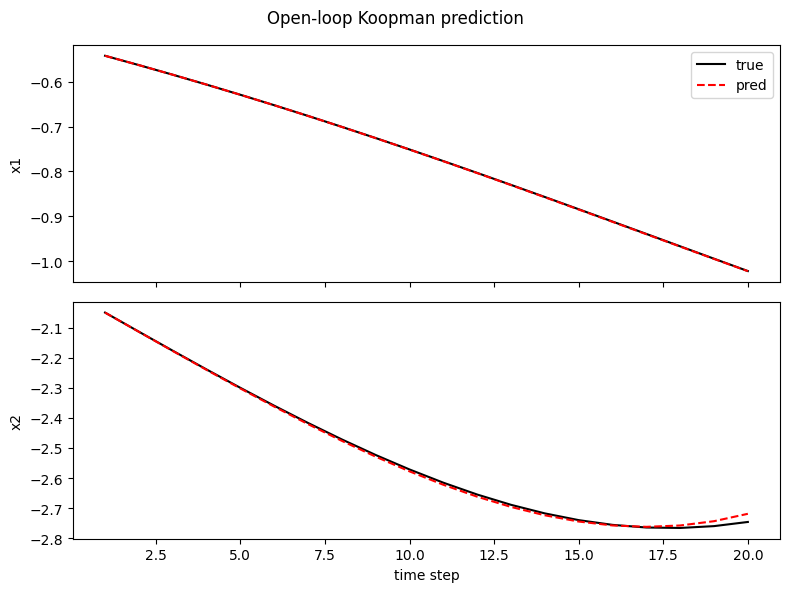

In [12]:
# Suppose state dim = 2, horizon N = 20, input dim = 1
n_x, N, m = 2, 20, 1
for i in range(10):
    psi_xt = Z[i,:].numpy()
    U_seq = U[i,:,:].reshape((N*m,))
    X_pred = open_loop_predict(E, F, psi_xt, U_seq, n_x, N)
    X_true = Yt[i,:,:].numpy()
    X_true = X_true.T
    # ground truth trajectory from dataset

    plot_trajectory(X_true, X_pred, title="Open-loop Koopman prediction")



    
    

In [13]:
error = np.zeros_like(X)
for i in range(Z.shape[0]):
    psi_xt = Z[i,:].numpy()
    U_seq = U[i,:,:].reshape((N*m,))
    X_pred = open_loop_predict(E, F, psi_xt, U_seq, n_x, N)
    X_true = Yt[i,:,:].numpy()
    error[i,:,:] = (X_true - X_pred.T)**2

print(error.mean(axis=(0, 1)))


[1.05432501e-08 1.61551564e-07 7.85515280e-07 2.39078596e-06
 5.63496247e-06 1.13071473e-05 2.03173160e-05 3.36917270e-05
 5.25738736e-05 7.82310588e-05 1.11999860e-04 1.55259266e-04
 2.09506626e-04 2.76367147e-04 3.57741398e-04 4.55676375e-04
 5.72838943e-04 7.12215043e-04 8.77657346e-04 1.07404138e-03]


In [14]:
#save mse_t_edmdc to npz file
np.savez_compressed("vdp_multistep_edmdc_mse.npz", mse_t_multistep = error.mean(axis=(0, 1)))

In [15]:
import cvxpy as cp
import numpy as np

def mpc_step(E, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N):
    """
    One MPC optimization step.
    
    E: (N*n_x, p)
    F: (N*n_x, N*m)
    psi_xt: (p,) lifted state at current x_t
    x_ref: (N, n_x) reference trajectory
    Q: (n_x, n_x) state cost
    R: (m, m) input cost
    umin, umax: (m,) lower/upper bounds for inputs
    """
    # decision variable: stacked inputs over horizon
    U = cp.Variable(N*m)

    # predicted stacked states
    stacked = E @ psi_xt + F @ U   # shape (N*n_x,)
    X_pred = cp.reshape(stacked, (N, n_x))

    # cost
    cost = 0
    for k in range(N):
        cost += cp.quad_form(X_pred[k, :] - x_ref[k, :], Q)
        if k < N:
            u_k = U[k*m:(k+1)*m]
            cost += cp.quad_form(u_k, R)

    # constraints
    constraints = []
    for k in range(N):
        u_k = U[k*m:(k+1)*m]
        constraints += [umin <= u_k, u_k <= umax]

    # solve
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        print("MPC infeasible, status:", prob.status)
        return None

    # return only first control move
    u0 = U.value[:m]
    return u0, X_pred.value

In [ ]:
# Example dims
n_x, m, N = 2, 1, 20
Ts       = 0.01
# current lifted state

# reference trajectory: e.g. zeros
x_ref = np.zeros((N, n_x))

# costs
Q = np.eye(n_x) * 1.0
R = np.eye(m) * 0.01

x0 = np.array([[2.0,1.0]])
# input constraints
umin = np.array([-10.0])
umax = np.array([ 10.0])
#store control actions and states
u_history = []
x_history = [x0.copy()]
for i in range(10000):
    x0t = torch.tensor(x0)
    psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
    psi_xt = np.squeeze(psi_xt.numpy())
    u0, Xpred = mpc_step(E, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N)
    x0 = np.array([rk4_step(x0[0], u0[0], Ts, mu, w0, b)])
    u_history.append(u0)
    x_history.append(x0.copy())

#save closed loop trajectory to npz file
np.savez_compressed("vdp_mpc_trajectory.npz", trajectory = x_history)
np.savez_compressed("vdp_mpc_u_history.npz", u_history = u_history)


[[2.00902672 0.80985328]]
[-4.11001661]
[[2.01631499 0.65164406]]
[-3.41504375]
[[2.02215897 0.52040297]]
[-2.83983899]
[[2.02680633 0.41180107]]
[-2.36447592]
[[2.03046447 0.32211076]]
[-1.97244946]
[[2.03330628 0.24815447]]
[-1.64979242]
[[2.03547539 0.1872461 ]]
[-1.3846529]
[[2.03709074 0.13713027]]
[-1.1670303]
[[2.03825061 0.09592329]]
[-0.9885498]
[[2.03903607 0.06205853]]
[-0.84224559]
[[2.03951389 0.03423725]]
[-0.72235414]
[[2.03973899 0.01138561]]
[-0.62412449]
[[ 2.03975653 -0.00738253]]
[-0.54365028]
[[ 2.03960359 -0.02279723]]
[-0.47772492]
[[ 2.03931064 -0.03545925]]
[-0.42371897]
[[ 2.03890266 -0.04586245]]
[-0.37947757]
[[ 2.03840016 -0.05441251]]
[-0.34323539]
[[ 2.03781996 -0.0614425 ]]
[-0.31354645]
[[ 2.03717586 -0.06722572]]
[-0.28922638]
[[ 2.03647918 -0.0719864 ]]
[-0.26930508]
[[ 2.0357392  -0.07590841]]
[-0.25298788]
[[ 2.03496352 -0.07914254]]
[-0.23962372]
[[ 2.03415841 -0.08181244]]
[-0.22867916]
[[ 2.03332896 -0.08401947]]
[-0.21971706]
[[ 2.0324794  -0.08

In [18]:
print(x0)
rk4_step(x0[0], u0[0], Ts, mu, w0, b)

[[ 0.00965776 -0.0005955 ]]


array([ 0.00965181, -0.00059518])

(40, 25)
25


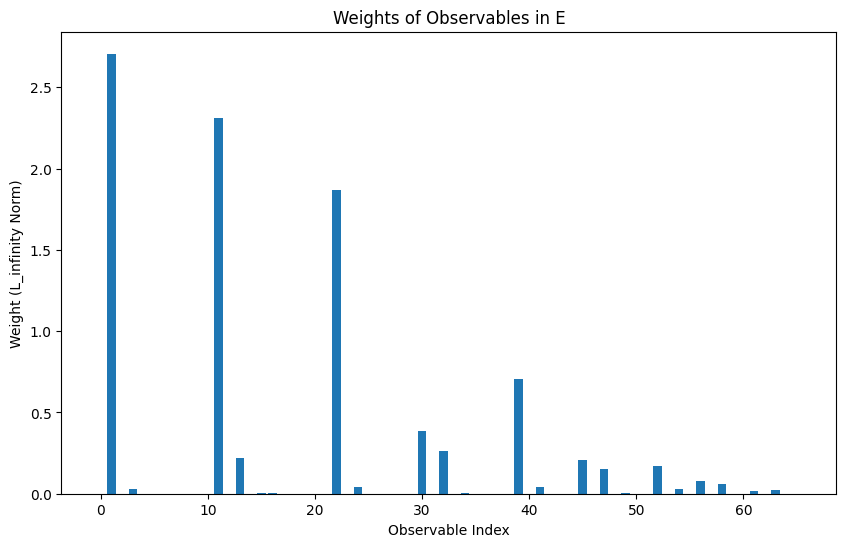

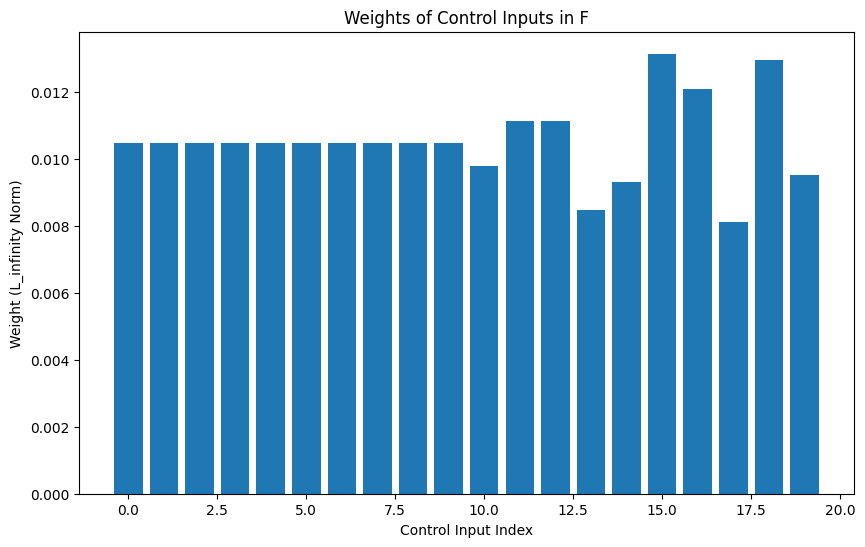

In [19]:
def prune(E,eps_E):
    idx = []
    for i in range(E.shape[1]):
        if np.linalg.norm(E[:,i],ord =float('inf')) > eps_E:
            idx.append(i)
    E_pruned = E[:,idx]

    return E_pruned, idx

E_pruned, idx = prune(E,1e-3)
print(E_pruned.shape)
print(len(idx))


def plot_obsevable_weights(E):
    """
    Plot the weights of the observables in E.
    """

    num_observables = E.shape[1]
    weights = np.linalg.norm(E, ord = float('inf'), axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_observables), weights)
    plt.xlabel('Observable Index')
    plt.ylabel('Weight (L_infinity Norm)')
    plt.title('Weights of Observables in E')
    plt.show()

plot_obsevable_weights(E)


def plot_control_weights(F):
    """
    Plot the weights of the control inputs in F.
    """

    num_controls = F.shape[1]
    weights = np.linalg.norm(F, ord = float('inf'), axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_controls), weights)
    plt.xlabel('Control Input Index')
    plt.ylabel('Weight (L_infinity Norm)')
    plt.title('Weights of Control Inputs in F')
    plt.show()
plot_control_weights(F)
def prune_observables(psi_xt, idx):
    """
    Prune the observables in psi_xt based on the indices in idx.
    """
    return psi_xt[idx]


x0 = np.array([[2.0,1.0]])
x0t = torch.tensor(x0)
psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
psi_xt = np.squeeze(psi_xt.numpy())
psi_xt_pruned = prune_observables(psi_xt, idx)

In [20]:
#compute open loop error for pruned model
error_pruned = np.zeros_like(X)
for i in range(Z.shape[0]):
    psi_xt = Z[i,:].numpy()
    psi_xt_pruned = prune_observables(psi_xt, idx)
    U_seq = U[i,:,:].reshape((N*m,))
    X_pred = open_loop_predict(E_pruned, F, psi_xt_pruned, U_seq, n_x, N)
    X_true = Yt[i,:,:].numpy()
    error_pruned[i,:,:] = (X_true - X_pred.T)**2

print(error_pruned.mean(axis=(0, 1)))
## save
np.savez_compressed("vdp_multistep_edmdc_pruned_mse.npz", mse_t_multistep_pruned = error_pruned.mean(axis=(0, 1)))

[1.05643625e-08 1.61865426e-07 7.86998542e-07 2.39517810e-06
 5.64504201e-06 1.13268534e-05 2.03518349e-05 3.37475594e-05
 5.26588966e-05 7.83545995e-05 1.12172614e-04 1.55493082e-04
 2.09814360e-04 2.76762609e-04 3.58243383e-04 4.56304585e-04
 5.73621219e-04 7.13182824e-04 8.78864476e-04 1.07554887e-03]


In [ ]:
# Example dims
n_x, m, N = 2, 1, 20
Ts       = 0.01
# current lifted state

# reference trajectory: e.g. zeros
x_ref = np.zeros((N, n_x))

# costs
Q = np.eye(n_x) * 1.0
R = np.eye(m) * 0.01

x0 = np.array([[2.0,1.0]])
# input constraints
umin = np.array([-10.0])
umax = np.array([ 10.0])
#store control actions and states
u_history = []
x_history = [x0.copy()]

for i in range(10000):
    x0t = torch.tensor(x0)
    psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
    psi_xt = np.squeeze(psi_xt.numpy())
    psi_xt_pruned = prune_observables(psi_xt, idx)
    u0, Xpred = mpc_step(E_pruned, F, psi_xt_pruned, x_ref, Q, R, umin, umax, n_x, m, N)
    x0 = np.array([rk4_step(x0[0], u0[0], Ts, mu, w0, b)])
    u_history.append(u0)
    x_history.append(x0.copy())




[[2.00902806 0.81011483]]
[-4.08182511]
[[2.01632008 0.65212546]]
[-3.38729915]
[[2.02216973 0.52105122]]
[-2.81433014]
[[2.02682416 0.4125646 ]]
[-2.34184347]
[[2.0304903  0.32294557]]
[-1.95268166]
[[2.03334065 0.24902589]]
[-1.63258406]
[[2.03551853 0.18812838]]
[-1.36960722]
[[2.03714267 0.13800519]]
[-1.15375672]
[[2.03831119 0.09677867]]
[-0.97670358]
[[2.03910506 0.06288673]]
[-0.83153851]
[[2.039591   0.03503403]]
[-0.71255234]
[[2.03982389 0.01214912]]
[-0.61504144]
[[ 2.0398489  -0.00665245]]
[-0.5351388]
[[ 2.0397031  -0.02209965]]
[-0.46966962]
[[ 2.03941696 -0.03479253]]
[-0.4160298]
[[ 2.0390155  -0.04522454]]
[-0.37208453]
[[ 2.03851924 -0.05380117]]
[-0.33608421]
[[ 2.03794503 -0.06085543]]
[-0.30659518]
[[ 2.03730669 -0.06666069]]
[-0.28244271]
[[ 2.03661555 -0.07144128]]
[-0.26266418]
[[ 2.03588093 -0.07538121]]
[-0.24647074]
[[ 2.03511045 -0.07863147]]
[-0.23321584]
[[ 2.03431036 -0.08131585]]
[-0.22236954]
[[ 2.03348582 -0.0835359 ]]
[-0.21349736]
[[ 2.03264103 -0.0

In [22]:
#save closed loop trajectory to npz file
np.savez_compressed("vdp_mpc_pruned_trajectory.npz", trajectory = x_history)
np.savez_compressed("vdp_mpc_pruned_u_history.npz", u_history = u_history)

In [23]:
np.savez_compressed("vdp_mpc_pruned_trajectory.npz", trajectory = x_history)
np.savez_compressed("control_pruned_history.npz", control = u_history)

In [24]:
print(E_pruned.shape)

(40, 25)


In [25]:
# comparing the time taken to solve 10000 mpc steps with and without pruning

import time
n_x, m, N = 2, 1, 20
start_time = time.time()
x0 = np.array([[2.0,1.0]])
N_sim = 1000
for i in range(N_sim):
    x0 = np.random.rand(1,2)*4 - 2
    x0t = torch.tensor(x0)
    psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
    psi_xt = np.squeeze(psi_xt.numpy())
    u0, Xpred = mpc_step(E, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N)
    x0 = np.array([rk4_step(x0[0], u0[0], Ts, mu, w0, b)])
end_time = time.time()
print("Time taken without pruning: ", end_time - start_time)
start_time = time.time()
x0 = np.array([[2.0,1.0]])
for i in range(N_sim): 
    x0 = np.random.rand(1,2)*4 - 2
    x0t = torch.tensor(x0)
    psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
    psi_xt = np.squeeze(psi_xt.numpy())
    psi_xt_pruned = prune_observables(psi_xt, idx)
    u0, Xpred = mpc_step(E_pruned, F, psi_xt_pruned, x_ref, Q, R, umin, umax, n_x, m, N)
    x0 = np.array([rk4_step(x0[0], u0[0], Ts, mu, w0, b)])
end_time = time.time()
print("Time taken with pruning: ", end_time - start_time)

Time taken without pruning:  52.46485924720764
Time taken with pruning:  51.889015436172485


In [26]:

#compute open loop error after pruning
    
